# SE-ResNet Implementation

In [1]:
from __future__ import print_function
from __future__ import absolute_import
from __future__ import division
from keras.models import Model
from keras.layers import *
from keras.regularizers import l2
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.engine.topology import get_source_inputs
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_applications.resnet50 import preprocess_input
from keras_applications.imagenet_utils import decode_predictions
from keras import backend as K
from datetime import datetime
from visualization import *
import time
from keras.optimizers import SGD,Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import numpy as np 
import pandas as pd
from keras.utils import to_categorical

Using TensorFlow backend.


Here we create out squeeze excite block, this is the main contribution of the paper and adds a global average pooling and 2 dense layers after the normal resnet block

In [2]:
#two parameters: input and reduction ratio
def squeeze_excite_block(input, ratio=16):
    filter_kernels = input._keras_shape[-1]
    z_shape = (1, 1, filter_kernels)
    z = GlobalAveragePooling2D()(input)
    z = Reshape(z_shape)(z)
    s = Dense(filter_kernels//ratio, activation='relu', use_bias=False)(z)
    s = Dense(filter_kernels, activation='sigmoid', use_bias=False)(s)
    x = multiply([input, s])
    return x

Here we create out final netwokr block which is basically a bottleneck resnet block followed by the squeeze and excite block

In [3]:
def se_resnet_block_bottleneck(input,channels,_strides=(1, 1)):
    chan_axis=-1
    if(input._keras_shape[-1]!=channels or _strides!=(1,1)):
        input = Conv2D(channels, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(input)
    
    x = Conv2D(channels, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(input)
    x = BatchNormalization(axis=chan_axis)(x)
    x = Activation('relu')(x)
    
    
    x = Conv2D(channels, (3, 3), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(x)
    x = BatchNormalization(axis=chan_axis)(x)
    x = Activation('relu')(x)
    
    
    x = Conv2D(channels, (1, 1), padding='same', kernel_initializer='he_normal',
                      use_bias=False, strides=_strides)(x)
    x = BatchNormalization(axis=chan_axis)(x)
    x = Activation('relu')(x)
    
    
    x = squeeze_excite_block(x)
    out = add([x, input])
    return out

Here we implement the architecture given in the paper diagram using for loops and adding blocks continuously

In [4]:
def se_resnet(input,filters = [64,128,256,512],depth = [6,8,12,6],num_classes=10, weight_decay=1e-4):
    chan_axis=-1
    x = Conv2D(filters[0], (7, 7), padding='same', use_bias=False, strides=(2, 2),
               kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay))(input)
    x = MaxPooling2D(pool_size=(2,2))(x)
    for i in range(len(filters)):
        x = se_resnet_block_bottleneck(x,filters[i],(2,2))
        for j in range(depth[i]-1):
            x = se_resnet_block_bottleneck(x,filters[i],(1,1))
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax', use_bias=False)(x)
    return x

Load the MNIST dataset here and create the create_model function that just uses the functions above to create our final model and return it.

In [5]:
from keras.datasets import mnist
(train_x, train_y) , (test_x, test_y) = mnist.load_data()
train_x = np.expand_dims(train_x,axis=3)
#train_y = np.expand_dims(train_y,axis=1)
train_y = to_categorical(train_y)
test_x = np.expand_dims(test_x,axis=3)
test_y = to_categorical(test_y)


def create_model(input_shape = (28, 28, 1),filters = [64,128,256,512],depth = [6,8,12,6],num_classes=10, weight_decay=1e-4):
    input = Input(shape = input_shape)
    x = se_resnet(input,filters,depth,num_classes)
    model = Model(input, x)
    print(model.summary())
    return model

In [6]:
print(train_x.shape)

(60000, 28, 28, 1)


Creating the model and printing the architecture

In [7]:
model = create_model()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 14, 14, 64)   3136        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 7, 7, 64)     0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 4, 64)     4096        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
conv2d_3 (

Basic Training code

In [8]:
#model_filename:where the model is checkpointed
model_id = 1
model_dir = './'
timestr = time.strftime("%Y%m%d-%H%M%S")
model_filename = model_dir + '{}-{}.hdf5'.format(model_id, timestr)
print('model checkpoint file path: {}'.format(model_filename))
lr_reduction_factor = 0.2
min_learning_rate = 1e-07
#Adding early stopping,model_checkpoint,reduceLRonPlateau
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3,
                           min_delta=0, 
                           verbose=1,
                           mode='auto')

model_checkpoint = ModelCheckpoint(model_filename,
                                   monitor='val_loss',
                                   verbose=1,
                                   save_best_only=True)

reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=lr_reduction_factor,
                             patience=2,
                             verbose=1,
                             min_lr=min_learning_rate,
                             epsilon=1e-4)
training_start_time = datetime.now()
model.compile(optimizer=Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])
history = model.fit(train_x,train_y,batch_size=32,epochs=100,verbose=1,callbacks=[model_checkpoint, early_stop, reduceLR],validation_data=(test_x, test_y))
time_spent_trianing = datetime.now() - training_start_time
print('model training complete. time spent: {}'.format(time_spent_trianing)) time spent: {}'.format(time_spent_trianing))

model checkpoint file path: ./1-20181109-222507.hdf5


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:999: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 199s 3ms/step - loss: 1.7666 - acc: 0.7969 - val_loss: 0.9411 - val_acc: 0.8985

Epoch 00001: val_loss improved from inf to 0.94109, saving model to ./1-20181109-222507.hdf5
Epoch 2/100
60000/60000 [==============================] - 182s 3ms/step - loss: 1.2153 - acc: 0.8685 - val_loss: 1.1228 - val_acc: 0.8953

Epoch 00002: val_loss did not improve from 0.94109
Epoch 3/100
60000/60000 [==============================] - 185s 3ms/step - loss: 0.9359 - acc: 0.9009 - val_loss: 1.7641 - val_acc: 0.7658

Epoch 00003: val_loss did not improve from 0.94109

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/100
60000/60000 [==============================] - 189s 3ms/step - loss: 0.7529 - acc: 0.9255 - val_loss: 0.7374 - val_acc: 0.9343

Epoch 00004: val_loss improved from 0.94109 to 0.73740, saving model to ./1-20181109-222507.hdf5
Epoch 5/100
6000

60000/60000 [==============================] - 207s 3ms/step - loss: 0.2195 - acc: 0.9841 - val_loss: 0.3000 - val_acc: 0.9702

Epoch 00036: val_loss improved from 0.30123 to 0.29998, saving model to ./1-20181109-222507.hdf5
Epoch 37/100
60000/60000 [==============================] - 207s 3ms/step - loss: 0.2145 - acc: 0.9841 - val_loss: 0.2983 - val_acc: 0.9698

Epoch 00037: val_loss improved from 0.29998 to 0.29827, saving model to ./1-20181109-222507.hdf5
Epoch 38/100
60000/60000 [==============================] - 206s 3ms/step - loss: 0.2124 - acc: 0.9841 - val_loss: 0.2956 - val_acc: 0.9706

Epoch 00038: val_loss improved from 0.29827 to 0.29561, saving model to ./1-20181109-222507.hdf5
Epoch 39/100
60000/60000 [==============================] - 206s 3ms/step - loss: 0.2103 - acc: 0.9847 - val_loss: 0.2947 - val_acc: 0.9709

Epoch 00039: val_loss improved from 0.29561 to 0.29472, saving model to ./1-20181109-222507.hdf5
Epoch 40/100
60000/60000 [==============================] - 2

Printing the training statistics

{'acc': [0.7968666666666666, 0.8685, 0.9009, 0.9254666666666667, 0.92795, 0.9386833333333333, 0.9480666666666666, 0.9542833333333334, 0.9552333333333334, 0.95475, 0.9604166666666667, 0.9613666666666667, 0.9627333333333333, 0.9596833333333333, 0.9629, 0.9662333333333334, 0.96695, 0.9687333333333333, 0.9702333333333333, 0.96945, 0.9725666666666667, 0.9728833333333333, 0.9740333333333333, 0.9771333333333333, 0.97975, 0.9801666666666666, 0.9806166666666667, 0.9805333333333334, 0.98095, 0.9819333333333333, 0.98225, 0.9822666666666666, 0.9825333333333334, 0.9830833333333333, 0.9833166666666666, 0.9840666666666666, 0.9841333333333333, 0.98415, 0.9846666666666667, 0.9844666666666667, 0.9847333333333333, 0.9848333333333333], 'loss': [1.766570236279567, 1.2153313704480728, 0.9359473824123542, 0.7528933323204517, 0.8241054387420416, 0.7145960925117135, 0.6399572514941295, 0.56269377814581, 0.5603003170053165, 0.5677226155792674, 0.49146803734799227, 0.4836316032325228, 0.4618825278525551, 0.53131

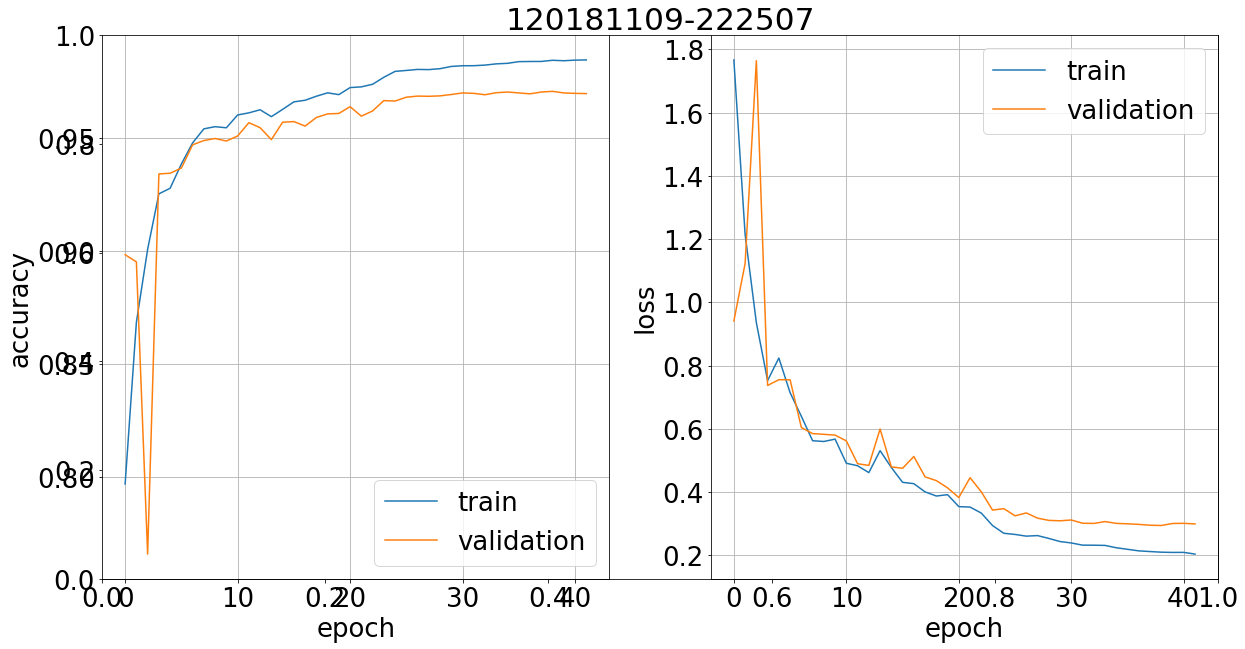

In [13]:
import pickle
print(history.history)

historyFilePath = model_dir + '{}-{}-train-history.png'.format(model_id, timestr)
trainingHistoryPlot(str(model_id) + str(timestr), historyFilePath, history.history)

pickleFilePath = model_dir + '{}-{}-history-dict.pickle'.format(model_id, timestr)
with open(pickleFilePath, 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Loading the model and evaluating Test set accuracy again

In [8]:
model_filename = './1-20181109-222507.hdf5'
model_id = 1
model_dir = './'
model.load_weights(model_filename)
model.compile(optimizer=Adam(0.001),loss="categorical_crossentropy",metrics=["accuracy"])
score = model.evaluate(test_x, test_y, verbose=0)
print('Accuracy: ',score[1])

Accuracy:  0.9709


Got a test accuracy of around 97%. Accuracy can be improved by adding methods such as cutout, data augmentation and distortion.